In [1]:
### Setting up environment
import numpy as np
from scipy.io import loadmat
from scipy.signal import correlate, resample
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
sonardata = loadmat('sonardata2.mat')
print('keys =', sonardata.keys())
print('data shape =', sonardata['data'].shape)

keys = dict_keys(['__header__', '__version__', '__globals__', 'data', 'fs', 't_0', 'T_p', 'B', 'c', 'fc'])
data shape = (8192, 32)


In [3]:
fs = float(sonardata['fs'])
tp = float(sonardata['T_p'])
t0 = float(sonardata['t_0'])
B = float(sonardata['B'])
Ns = int(tp*fs)
c = float(sonardata['c'])
X = sonardata['data'][:1600]
Nt, Nh = X.shape

alpha = B/tp
ts = np.linspace(-tp/2,tp/2,Ns)
s = np.exp(1j*np.pi*alpha*ts**2)

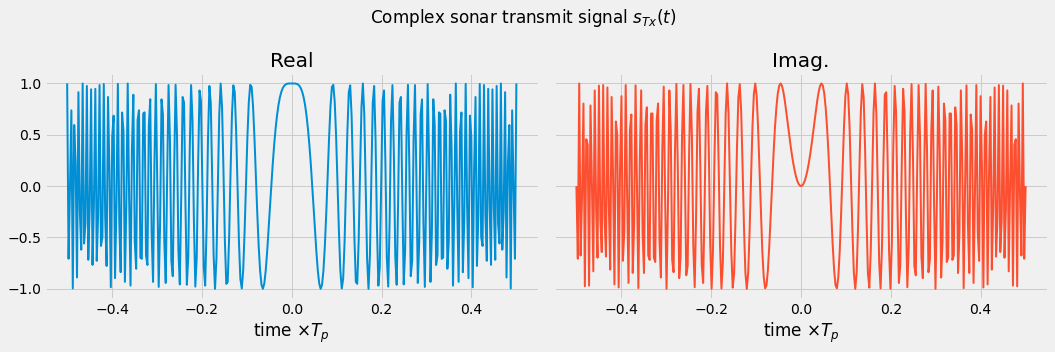

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Complex sonar transmit signal $s_{Tx}(t)$')

ax = axes[0]
ax.set_title('Real')
ax.plot(ts/tp, np.real(np.exp(1j*np.pi*alpha*ts**2)), lw=2)
ax.set_xlabel(r'time $\times T_p$')

ax = axes[1]
ax.set_title('Imag.')
ax.plot(ts/tp, np.imag(np.exp(1j*np.pi*alpha*ts**2)), lw=2, color=COLORS[1])
ax.set_xlabel(r'time $\times T_p$')

plt.tight_layout()
plt.show()

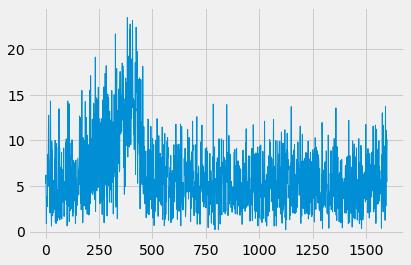

In [5]:
plt.plot(np.abs(X[:,2]), lw=1)

In [6]:
def matched_filtering(X, s):
    '''Performs matched filtering of X by s. X is the received signal of an array ordered by (channel, signal).'''
    xc = np.empty(X.shape, dtype=np.complex)
    for i, x in enumerate(X.T):
        xc[:,i] = correlate(x, s, mode='same')
    return xc

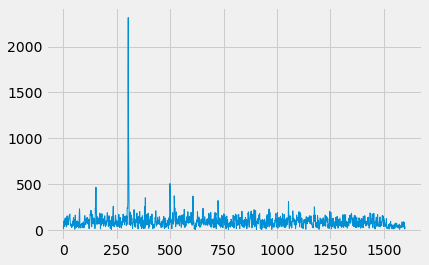

In [7]:
xc = matched_filtering(X, s)
plt.plot(np.abs(xc[:,2]), lw=1)

In [8]:
def peak_indexes(X, start=None, end=None):
    '''Returns array with peaks along X's second axis in the range (start:end)'''
    peak_idx = np.argmax(np.abs(X[start:end]), axis=0)
    return peak_idx

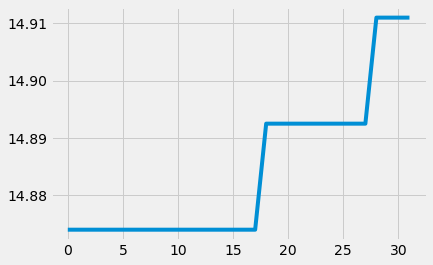

In [9]:
n0_ml = peak_indexes(xc)
r_ml = (t0 + n0_ml/fs)*c/2
plt.plot(r_ml)

In [10]:
s_up4 = resample(s, 4*Ns)
s_up8 = resample(s, 8*Ns)

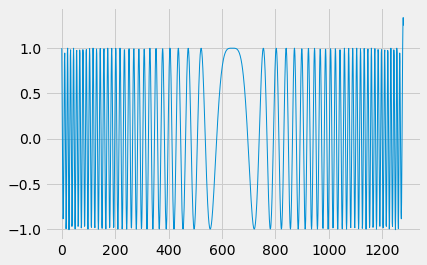

In [11]:
plt.plot(s_up4.real, lw=1)

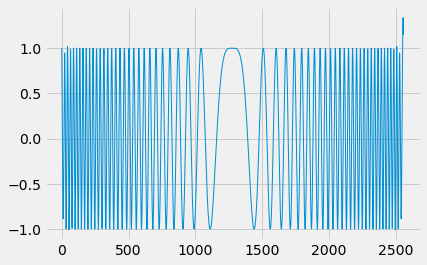

In [12]:
plt.plot(s_up8.real, lw=1)

In [13]:
def upsample_array(X, up=4):
    Nt, Nh = X.shape
    X_up = np.empty((up*Nt, Nh), dtype=np.complex)
    for i, x in enumerate(X.T):
        X_up[:,i] = resample(x, up*Nt)
    return X_up

In [14]:
def xcorr(X, s, up=1):
    samples = upsample_array(X, up=up)
    ping = resample(s, up*len(s))
    xc = matched_filtering(samples, ping)
    return xc

In [15]:
xc_up4 = matched_filtering(upsample_array(X, up=4), s_up4)
xc_up8 = matched_filtering(upsample_array(X, up=8), s_up8)

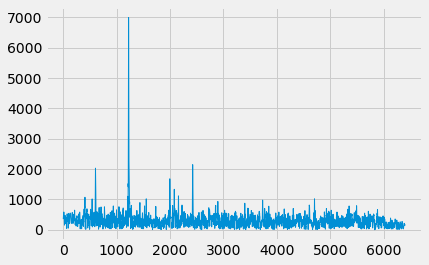

In [16]:
plt.plot(np.abs(xc_up4[:, 30]), lw=1)

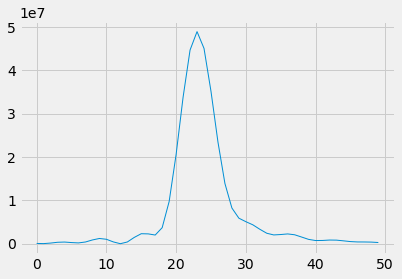

In [17]:
plt.plot(np.abs(xc_up4[1200:1250, 30])**2, lw=1)

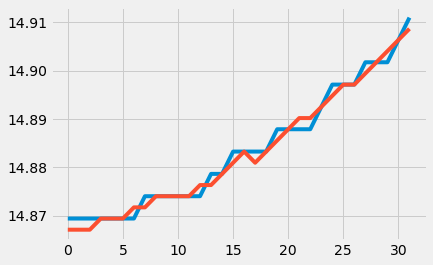

In [18]:
n0_ml = peak_indexes(xc_up4, end=1600*4)
r_ml = (t0 + n0_ml/(fs*4))*c/2
plt.plot(r_ml)

n0_ml = peak_indexes(xc_up8, end=1600*8)
r_ml = (t0 + n0_ml/(fs*8))*c/2
plt.plot(r_ml)

In [19]:
def lse(X, t):
    _, Nh = X.shape
    T = np.empty((3, Nh))    
    for i, x in enumerate(X.T):
        nonzero_idx = np.nonzero(x)
        x_nz = x[nonzero_idx]
        t_nz = t[nonzero_idx].reshape(-1,1)
        H = np.hstack((np.ones((len(t_nz),1)), t_nz, t_nz**2))
        T[:,i] = np.linalg.inv(H.T @ H) @ H.T @ x_nz
    
    sigma2 = -1/(2*T[2])
    tau0 = -T[1]/(2*T[2])
    I0 = np.exp(T[0] - T[1]**2/(4*T[2]))
    return (sigma2, tau0, I0)

In [20]:
def pulse_mask(X):
    X = np.abs(X)**2
    peaks = np.amax(X, axis=0)
    mask = X > .5*peaks
    return mask

In [21]:
up = 8
xc = np.abs(xcorr(X, s, up=up)/(up*Nt))
mask = pulse_mask(xc)
xlog = np.log(xc)*mask
t = np.linspace(0, Nt/fs, up*Nt)
res = lse(xlog, t)

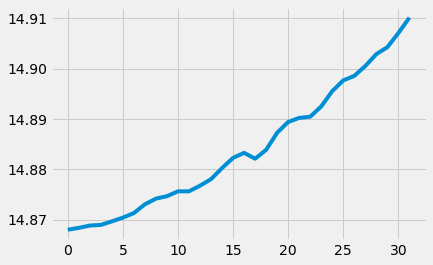

In [22]:
sigma2, tau, I0 = res
r_ml = (t0 + tau)*c/2
plt.plot(r_ml)

In [23]:
sigma20, tau0, I00 = sigma2[0], tau[0], I0[0]

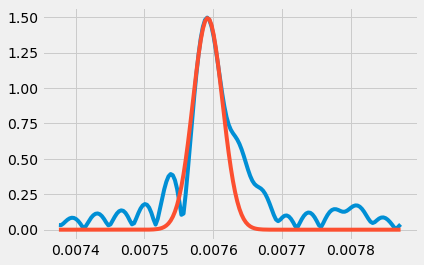

In [28]:
start, end = 295*up, 315*up
time = t[start:end]
plt.plot(time, xc[start:end, 0])
plt.plot(time, I00*np.exp(-(time-tau0)**2 / (2*sigma20)))